## Imports

In [8]:
import os
import json
import random
import torch
import torchaudio
from kan import KAN
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchaudio.transforms as T

import librosa
import matplotlib.pyplot as plt

from tqdm import tqdm_gui as tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Utils

In [3]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.numel() * param.element_size()  # element_size in bytes
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.numel() * buffer.element_size()
    
    total_size_mb = (param_size + buffer_size) / (1024 ** 2)  # in MB
    print(f'Model size: {total_size_mb:.4f} MB')
    return total_size_mb


In [4]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_mono_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = 1, waveform.shape[0]
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform, linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

Processing:  ./data/Dipco/transcriptions\dev\S02.json


C:\Users\chaud\AppData\Local\Temp\ipykernel_18720\3950307762.py:22: TqdmExperimentalWarning: GUI is experimental/alpha
  for utt in tqdm(session_trans):


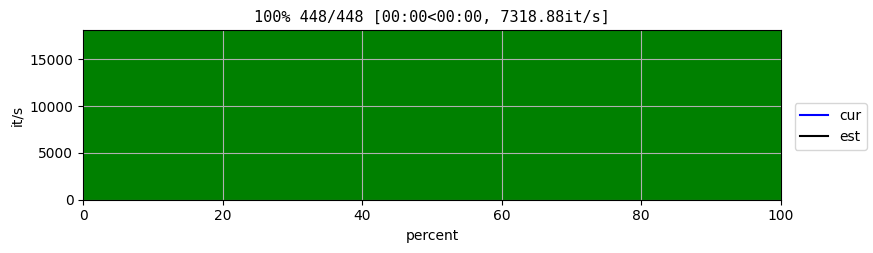

Processing:  ./data/Dipco/transcriptions\dev\S04.json


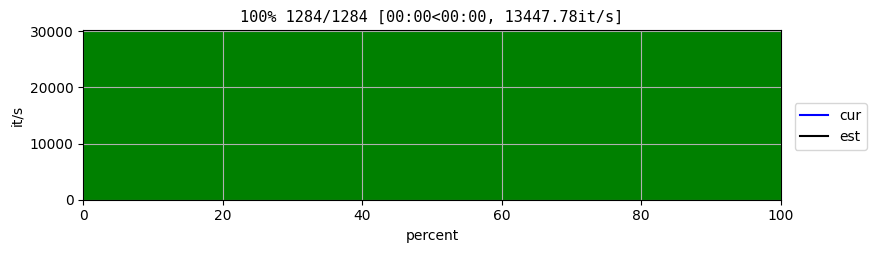

('S02', 'P05') 200 [(39360, 103360), (133600, 197600), (1278720, 1342720), (1465600, 1529600), (1524640, 1588640), (1568480, 1632480), (1729120, 1793120), (1761440, 1825440), (1825440, 1889440), (2124640, 2188640), (2210560, 2274560), (2295680, 2359680), (2494560, 2558560), (2544160, 2608160), (2698400, 2762400), (2886400, 2950400), (2943360, 3007360), (3007200, 3071200), (3083040, 3147040), (3187360, 3251360), (3793920, 3857920), (4046240, 4110240), (4212800, 4276800), (4276800, 4340800), (4330880, 4394880), (4344000, 4408000), (4424640, 4488640), (4571520, 4635520), (4635520, 4699520), (4658240, 4722240), (4712320, 4776320), (4783200, 4847200), (4835520, 4899520), (5151520, 5215520), (5215520, 5279520), (5239680, 5303680), (5296640, 5360640), (5360640, 5424640), (5424640, 5488640), (5483040, 5547040), (5547040, 5611040), (5611040, 5675040), (5675040, 5739040), (5731680, 5795680), (5764480, 5828480), (5825280, 5889280), (5891360, 5955360), (5915680, 5979680), (5979680, 6043680), (6043

(2417188,
 (('S02', 'P05'), (39360, 103360), ('S02', 'P06'), (171520, 235520)),
 151075)

In [57]:
from datetime import datetime
import time

class DiPCoSeparationDataset(Dataset):
    def __init__(self, root_dir='./data/Dipco/', session_ids=['S02', 'S04'], version='dev', 
                segment_length=4, sr=16000, max_pairs=10000):
        
        self.sr = sr
        self.segment_samples = int(sr * segment_length)
        
        self.session_dict:dict[list] = {}
        self.pairs = []
        self.session_audio:dict[tuple[str, str],torch.Tensor] = {}
        

        for session_id in session_ids:
            trans_path = os.path.join(root_dir, 'transcriptions', version, f'{session_id}.json')
            print('Processing: ', trans_path)
            with open(trans_path, 'r') as f:
                session_trans = json.load(f)

            for utt in tqdm(session_trans):
                curr_speaker_id = utt['speaker_id']
                curr_valid_times = self.session_dict.get((session_id, curr_speaker_id), [])
                curr_start_time = self._time_str_to_sample(utt['start_time'], sr)
                curr_end_time = self._time_str_to_sample(utt['end_time'], sr)
                
                curr_valid_times.extend([(start, start + segment_length * sr) for start in range(curr_start_time, curr_end_time, self.segment_samples)])
                self.session_dict[(session_id, curr_speaker_id)] = curr_valid_times


            for speaker_1 in list(self.session_dict.keys())[:-1]:
                if speaker_1[0] != session_id:
                    continue
                speaker_1_times = self.session_dict[speaker_1]
                for speaker_2 in list(self.session_dict)[1:]:
                    if speaker_2[0] != session_id:
                        continue
                    speaker_2_times = self.session_dict[speaker_2]
                    for time1 in speaker_1_times:
                        for time2 in speaker_2_times:
                            self.pairs.append((speaker_1, time1, speaker_2, time2))

        for (key_session_id, key_speaker_id), times in self.session_dict.items():
            print((key_session_id, key_speaker_id), len(times), times)
            audio_path = os.path.join(root_dir, 'audio', version,
                                    f"{key_session_id}_{key_speaker_id}.wav")
            self.session_audio[(key_session_id, key_speaker_id)] = self._load_full_audio(audio_path)

            print((key_session_id, key_speaker_id),len(self.session_audio[(key_session_id, key_speaker_id)]))


    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        (speaker_1, time1, speaker_2, time2) = self.pairs[idx]
        clean1 = self.session_audio[speaker_1][time1[0]:time1[1]]
        clean2 = self.session_audio[speaker_2][time2[0]:time2[1]]

        mixed = (clean1 + clean2).clamp(-1, 1)

        clean1 = clean1.unsqueeze(0)
        clean2 = clean2.unsqueeze(0)
        mixed = mixed.unsqueeze(0)

        return mixed, torch.stack([clean1, clean2])

    def _time_str_to_sample(self, t_dict, sr):
        t_str = t_dict[list(t_dict.keys())[0]]
        t = datetime.strptime(t_str, "%H:%M:%S.%f")
        return int(sr * (t.hour * 3600 + t.minute * 60 + t.second + t.microsecond / 1_000_000))
    
    def _load_full_audio(self, path):
        waveform, orig_sr = torchaudio.load(path)
        if orig_sr != self.sr:
            resampler = torchaudio.transforms.Resample(orig_sr, self.sr)
            waveform = resampler(waveform)
        waveform = torch.mean(waveform, dim=0)  # Convert to mono
        return waveform

    def _pad_time(self):
        pass


dataset = DiPCoSeparationDataset()
len(dataset)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
len(dataset.pairs), dataset.pairs[0], len(train_loader)

torch.Size([16, 1, 64000]) torch.Size([16, 2, 1, 64000])


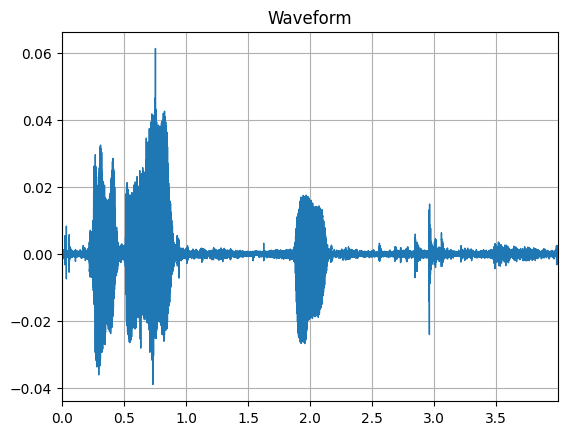

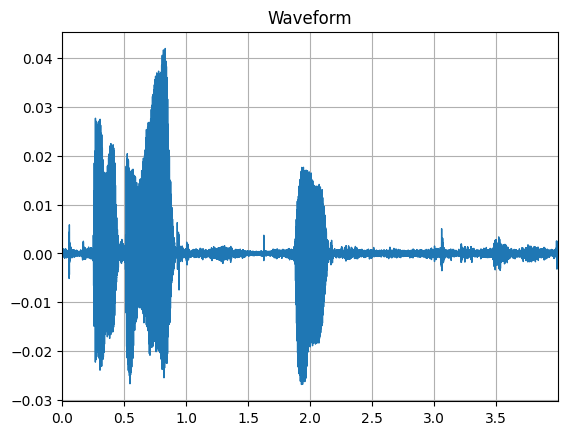

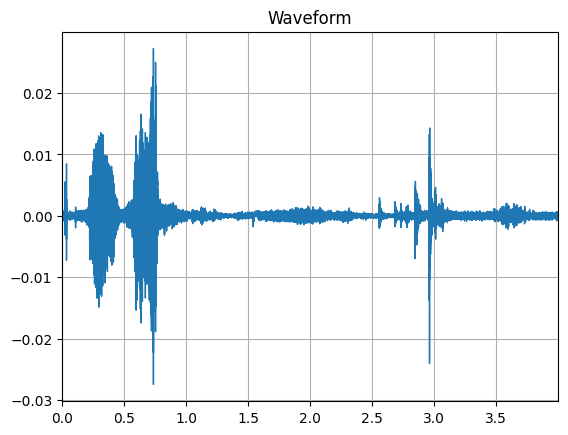

In [59]:
for mixed, clean in train_loader:
    print(mixed.shape, clean.shape)
    plot_waveform(mixed[0], sr=16000)
    plot_waveform(clean[0][0], sr=16000)
    plot_waveform(clean[0][1], sr=16000)
    break

## Training

In [ ]:
class PermutationInvariantSISNRLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps = 1e-8

    def _si_snr(self, estimates, targets):
        # estimates: [B, T]
        # targets: [B, T]
        estimates = estimates - estimates.mean(dim=-1, keepdim=True)
        targets = targets - targets.mean(dim=-1, keepdim=True)

        # Compute SI-SNR
        s_target = (torch.sum(estimates * targets, dim=-1, keepdim=True) * targets) \
                   / (torch.norm(targets, p=2, dim=-1, keepdim=True)**2 + self.eps)
        
        e_noise = estimates - s_target
        return 10 * torch.log10(
            (torch.norm(s_target, p=2, dim=-1)**2 + self.eps) / 
            (torch.norm(e_noise, p=2, dim=-1)**2 + self.eps)
        )

    def forward(self, outputs, targets):
        """
        Args:
            outputs: [B, 2, T] separated waveforms
            targets: [B, 2, T] original clean waveforms
        Returns:
            loss: scalar
        """
        # Compute all permutations
        loss_0 = self._si_snr(outputs[:,0], targets[:,0]) + \
                 self._si_snr(outputs[:,1], targets[:,1])
        
        loss_1 = self._si_snr(outputs[:,0], targets[:,1]) + \
                 self._si_snr(outputs[:,1], targets[:,0])

        # Return negative of best permutation
        return -torch.mean(torch.min(loss_0, loss_1))


In [60]:
from torchaudio.models import ConvTasNet

model = ConvTasNet(num_sources=2, enc_kernel_size=16, enc_num_feats=16,msk_kernel_size=3, msk_num_feats=8, msk_num_hidden_feats=16, msk_num_layers=3, msk_num_stacks=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# criterion = PermutationInvariantLoss()
criterion  = PermutationInvariantSISNRLoss()

for epoch in range(50):
    epoch_loss = 0
    for s_idx, (mixed, clean) in tqdm(enumerate(train_loader), desc=f'Epoch {epoch + 1}', position=epoch, total=len(train_loader)):
        # print(mixed.shape, clean.shape)
        mixed = mixed.to(device)
        clean = clean.to(device)
        optimizer.zero_grad()
        outputs = model(mixed)
        # print(outputs.shape)
        loss = criterion(outputs, clean)
        if s_idx % 1000 == 0:
            print(loss)
        # print(loss.item())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
